In [3]:
import pickle
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

In [4]:
# Load the dataset ...
#  You will need to seperately download or generate this file
f = open("RML2016.10a_dict.dat",'rb')
Xd = pickle.load(f, encoding='latin-1')
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [5]:
# Partition the data
#  into training and test sets of the form we can train/test on 
#  while keeping SNR and Mod labels handy for each
factor = 0.7 # % of training data
np.random.seed(2018)
n_examples = X.shape[0]
n_train = int(n_examples * factor)
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]
def to_onehot(yy):
    yy = list(yy)
    yy1 = np.zeros([len(yy), max(yy)+1])
    yy1[np.arange(len(yy)),yy] = 1
    return yy1
Y_train = to_onehot(map(lambda x: mods.index(lbl[x][0]), train_idx))
Y_test = to_onehot(map(lambda x: mods.index(lbl[x][0]), test_idx))
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(154000, 2, 128) [2, 128]


In [25]:
nfft = 16
cyclo_averaging = 8
offsets = [1,2,3,4,5,6,7,8]

def compute_cyclo_fft(data, nfft):
    data_reshape = np.reshape(data, (nfft, -1))
    return np.fft.fftshift(np.fft.fft(data_reshape, axis=0), axes=0)

def compute_cyclo_ifft(data, nfft):
    return np.fft.fftshift(np.fft.fft(data))

def single_fft_cyclo(fft, offset):
    left = np.roll(fft, -offset)
    right = np.roll(fft, offset)
    spec = right * np.conj(left)
    return spec

def create_sc(spec, offset):
    left = np.roll(spec, -offset)
    right = np.roll(spec, offset)
    denom = left * right 
    denom_norm = np.sqrt(denom)
    return np.divide(spec, denom_norm)

def cyclo_stationary(data):
    # fft
    cyc_fft = compute_cyclo_fft(data, nfft)
    # average
    num_ffts = int(cyc_fft.shape[0])
    cyc_fft = cyc_fft[:num_ffts]
    cyc_fft = np.mean(np.reshape(cyc_fft, (nfft, cyclo_averaging)), axis=1)
    specs = np.zeros((len(offsets)*16), dtype=np.complex64)
    scs = np.zeros((len(offsets)*16), dtype=np.complex64)
    cdp = {offset: 0 for offset in offsets}
    for j, offset in enumerate(offsets):
        spec = single_fft_cyclo(cyc_fft, offset)
        sc = create_sc(spec, offset)
        specs[j*16:j*16+16] = spec
        scs[j*16:j*16+16] = sc
        cdp[offset] = max(sc)
    return specs, scs, cdp
    
def extract_features(X):
    ndata = X.shape[0]
    feat_specs = np.zeros((ndata, len(offsets)*16), dtype=np.complex64)
    feat_scs = np.zeros((ndata, len(offsets)*16), dtype=np.complex64) 
    cdps = [0 for _ in range(ndata)]
    for i in range(ndata):
        A = (X[i][0] + X[i][1])
        feat_specs[i], feat_scs[i], cdps[i] = cyclo_stationary(A)
    return feat_specs, feat_scs, cdps

/Users/NJ/anaconda/lib/python3.6/site-packages/numpy/core/numeric.py:531: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


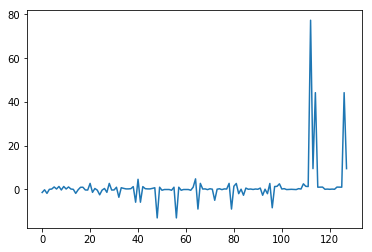

In [30]:
X_train = Xd[('QPSK', 18)]
feats_specs, feats_scs, cdps = extract_features(X_train)
plt.plot(np.arange(128), feats_scs[200])
plt.show()